In [93]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import mean_absolute_error
from data_farming.helpers import csv_to_df
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [94]:
# definitions
ROOT_DIR = '/Users/aja23083/Projects/Python/dapi_counter/'
PATH = {
    "IMAGE_IN": os.path.join(ROOT_DIR, 'data/z_stack_images/'),
    "IMAGE_OUT": os.path.join(ROOT_DIR, 'data/z_stack_processed/'),
    "CSV": os.path.join(ROOT_DIR, 'data/z_stack_images.csv'),
}

In [95]:
data = []
labels = []
locations = []

df = csv_to_df(PATH['CSV'])
df_shuffle = df.sample(frac=1).reset_index(drop=True)

In [96]:
# check
def check(image, locations, count):
    plt.imshow(image)
    x = [loc[0] for loc in locations]
    y = [loc[1] for loc in locations]
    plt.plot(x,y, 'yX')
#     print('len(locations) == count? =>', len(locations) == count)
    assert len(locations) / 93 == count, 'The cell count and number of locations do not match'
    print('image shape:', image.shape)
    plt.show()

In [97]:
for i, image in enumerate(df_shuffle['name']):
    im_path = os.path.join(PATH['IMAGE_OUT'] + image)
    img = cv2.imread(im_path)
    # shape is (256, 256, 1)
    data.append(img)
    label = df_shuffle['count'][i]
    loc = df_shuffle['locations'][i]
    labels.append(label)
    locations.append(loc)


In [98]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels) / max(labels)
locations = np.array(locations)

In [129]:
# locations atm is a nd.array containing lists, should be a 3d nd.array
# after that we can / 256 to get the relative locations of all the pixels

image shape: (256, 256, 3)


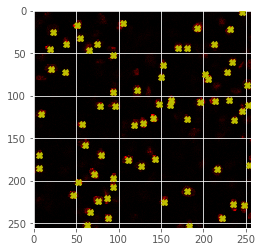

image shape: (256, 256, 3)


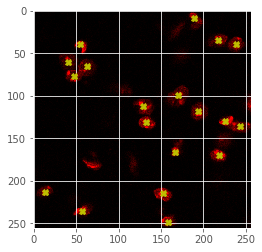

image shape: (256, 256, 3)


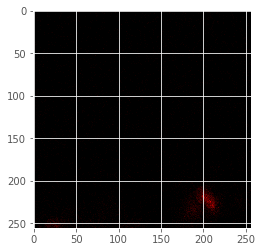

image shape: (256, 256, 3)


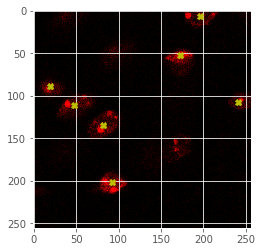

image shape: (256, 256, 3)


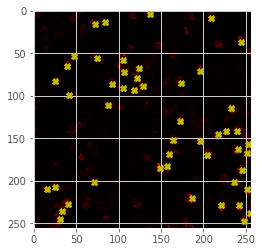

In [99]:
# check if cell count and locations are correct
for i in range(5):
    check(data[i], locations[i], labels[i])

In [100]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [135]:
# image augmentation?
# load trainX into keras Sequence

In [101]:
# get model + weights
base_model = InceptionResNetV2(include_top=False, pooling='avg')

In [102]:
outputs = tf.keras.layers.Dense(1, activation='linear')(base_model.output)
model = tf.keras.Model(base_model.inputs, outputs)

In [12]:
# transform grayscale image to 'fake' RGB:
#tf.image.grayscale_to_rgb(
#    images,
#    name=None
#)

In [43]:
# freeze all non output layers
for layer in base_model.layers:
    layer.trainable = False

In [122]:
# refitting weights
# 630 = start of 5 x Inception ResNet C
# 287 = start of 10 x Inception ResNet B

for layer in model.layers[:287]:
   layer.trainable = False
for layer in model.layers[287:]:
   layer.trainable = True

In [123]:
opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4 / 200)

In [124]:
model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [125]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
)

In [126]:
# set batch size and epochs
BS = 16
EPOCHS = 10

In [127]:
# input a keras sequence containing dataset
print("[INFO] training network for {} epochs...".format(EPOCHS))

H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS
)

[INFO] training network for 10 epochs...
Epoch 1/10
40/40 [==============================] - 530s 13s/step - loss: 41462.8343 - val_loss: 52677.1113
Epoch 2/10
40/40 [==============================] - 518s 13s/step - loss: 24340.6015 - val_loss: 64319.0191
Epoch 3/10
40/40 [==============================] - 479s 12s/step - loss: 95713.1454 - val_loss: 22510.4703
Epoch 4/10
40/40 [==============================] - 481s 12s/step - loss: 119261.5648 - val_loss: 73587.6293
Epoch 5/10
40/40 [==============================] - 484s 12s/step - loss: 5672.1843 - val_loss: 11756.6593
Epoch 6/10
40/40 [==============================] - 537s 13s/step - loss: 8612.9808 - val_loss: 6717.9944
Epoch 7/10
40/40 [==============================] - 551s 14s/step - loss: 3026.4214 - val_loss: 513.2274
Epoch 8/10
40/40 [==============================] - 539s 13s/step - loss: 9618.4142 - val_loss: 300.2488
Epoch 9/10
40/40 [==============================] - 543s 14s/step - loss: 20328.0152 - val_loss: 8277.7

In [130]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(mean_absolute_error(testY,
    predictions) * 93)

[INFO] evaluating network...
21.40248991790604


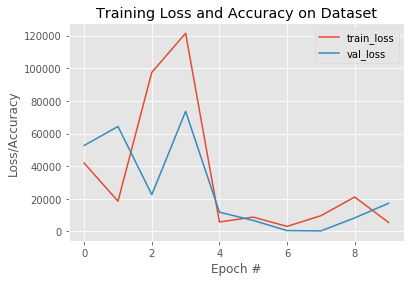

In [131]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

In [129]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_203
2 batch_normalization_203
3 activation_203
4 conv2d_204
5 batch_normalization_204
6 activation_204
7 conv2d_205
8 batch_normalization_205
9 activation_205
10 max_pooling2d_4
11 conv2d_206
12 batch_normalization_206
13 activation_206
14 conv2d_207
15 batch_normalization_207
16 activation_207
17 max_pooling2d_5
18 conv2d_211
19 batch_normalization_211
20 activation_211
21 conv2d_209
22 conv2d_212
23 batch_normalization_209
24 batch_normalization_212
25 activation_209
26 activation_212
27 average_pooling2d_1
28 conv2d_208
29 conv2d_210
30 conv2d_213
31 conv2d_214
32 batch_normalization_208
33 batch_normalization_210
34 batch_normalization_213
35 batch_normalization_214
36 activation_208
37 activation_210
38 activation_213
39 activation_214
40 mixed_5b
41 conv2d_218
42 batch_normalization_218
43 activation_218
44 conv2d_216
45 conv2d_219
46 batch_normalization_216
47 batch_normalization_219
48 activation_216
49 activation_219
50 conv2d_215
51 conv2d_217
52 conv2d_220